In [3]:
import geatpy as ea
import numpy as np

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   20   | 4.13333E+00 | 7.93333E+00 | 5.48833E+00 | 4.13333E+00 | 9.60282E-01 
 1 |   40   | 3.16667E+00 | 4.86667E+00 | 4.41000E+00 | 3.16667E+00 | 4.50568E-01 
 2 |   60   | 3.16667E+00 | 4.30000E+00 | 3.88500E+00 | 3.16667E+00 | 4.11295E-01 
 3 |   80   | 2.86667E+00 | 3.73333E+00 | 3.26333E+00 | 2.86667E+00 | 2.03825E-01 
 4 |  100   | 2.60000E+00 | 3.16667E+00 | 3.04333E+00 | 2.60000E+00 | 1.71626E-01 
 5 |  120   | 2.40000E+00 | 3.16667E+00 | 2.81833E+00 | 2.40000E+00 | 2.24963E-01 
 6 |  140   | 2.30000E+00 | 2.83333E+00 | 2.55333E+00 | 2.30000E+00 | 1.46211E-01 
 7 |  160   | 2.16667E+00 | 2.46667E+00 | 2.38833E+00 | 2.16667E+00 | 6.60597E-02 
 8 |  180   | 2.13333E+00 | 2.40000E+00 | 2.27667E+00 | 2.13333E+00 | 6.83943E-02 
 9 |  200   | 1.93333E+00 | 2.30000E+00 | 2.18167E+00 | 1.93333E+00 | 7.41433E-02 
 10|

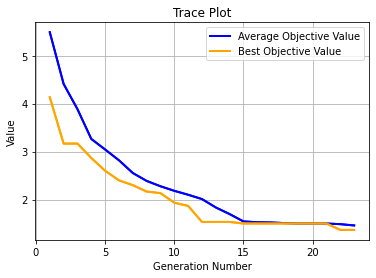

Execution time: 0.015975475311279297 s
Evaluation number: 460
The best objective value is: 1.3666666666666667
The best variables are: 
0	0	2	1	1	0	-1	0	2	2	2	1	1	2	3	2	0	1	0	-1	0	2	0	1	3	2	1	3	-1	2	


In [16]:
# 构建问题
r = 1  # 目标函数需要用到的额外数据
dim = 30 # 600 个变量好像优化不好
@ea.Problem.single
def evalVars(Vars):  # 定义目标函数（含约束）
    f = np.sum((Vars - r) ** 2)/dim  # 计算目标函数值
    # x1 = Vars[0]
    # x2 = Vars[1]
    # CV = np.array([(x1 - 0.5)**2 - 0.25,
    #                 (x2 - 1)**2 - 1])  # 计算违反约束程度
    CV = np.array([f-2000])
    return f, CV
# dim = 600 # 600 个变量好像优化不好
varTypes = np.ones(dim) # 整数
# varTypes = np.zeros(dim) # 实数
# lb = np.ones(dim)*1
# ub = np.ones(dim)*20
lb = np.ones(dim)*-3
ub = np.ones(dim)*3
problem = ea.Problem(name='soea quick start demo',
                        M=1,  # 目标维数
                        maxormins=[1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                        Dim=dim,  # 决策变量维数
                        varTypes=varTypes,  # 决策变量的类型列表，0：实数；1：整数
                        lb=lb,  # 决策变量下界
                        ub=ub,  # 决策变量上界
                        evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                    ea.Population(Encoding='RI', NIND=20),
                                    MAXGEN=500,  # 最大进化代数。
                                    logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                    trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                    maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, seed=1, verbose=True, drawing=1, outputMsg=True, drawLog=False, saveFlag=True, dirName='result')

In [13]:
import linear_model as model
import src.project1.submit.AI as ai
from experiment.评估函数.simulator import Simulator
from experiment.评估函数.greedy_ai import GreedyAI
import experiment.评估函数.greedys as greedys
chessboard_size = 8
time_out = 5
def greedy_fun(Vars):
    PVT, PVT_max = model.get_PVT_and_max(Vars)
    return lambda a, p : model.value_of_positions(a.reversi_env.updated_chessboard(a.chessboard, a.color, p), a.color, PVT, PVT_max)
# def evalWinRate(Vars, diff=0.001, at_least_times=20):
def evalWinRate(Vars, diff=0.001, at_least_times=20):
    wins = 0
    cnts = 0
    prev_prob = np.ones(at_least_times)*100  # 不合法
    prob = -1 # 不合法
    while np.absolute(prob-prev_prob).sum()>at_least_times*diff or prob==1:
        for i_color in [ai.COLOR_BLACK, ai.COLOR_WHITE]:
            agents = {i_color: GreedyAI(chessboard_size, i_color, greedy_fun(Vars)),
                  -i_color: GreedyAI(chessboard_size, -i_color, greedys.random_baseline)}
            simulator = Simulator(chessboard_size, time_out, agents)
            winner = simulator.quick_run(no_print=True)
            if winner != i_color:
                # print("loss")
                pass
            else:
                # print("win")
                wins += 1
            cnts += 1
            prev_prob = np.append(prev_prob[1:], prob)
            prob = wins/cnts
    print(cnts)
    return prob
# evalWinRate(np.array([1, 8, 3, 7, 3, 2, 5, 6, 6, 4]))
# 实验结果: diff为0.001时，338才收敛，估算出0.7603
# diff为 0.01时，50次收敛, 估算出0.66
# evalWinRate(np.array([9, 10, 18, 5, 19,15, 18, 13, 8, 3]))  # 演化结果1 0.8571
# evalWinRate(np.array([-1, 10, 18, 5, 19,15, 18, 13, 8, 3]))  # 0.75
# evalWinRate(np.array([3, 20, 5, 5, 18,15, 18, 13, 8, 3])) # 先验知识调参 0.6
# evalWinRate(np.array([16,14,18,18,20,20,13,12,18,15])) # 演化结果2 0.72
evalWinRate(np.array([0.58294678,  0.32422638,  0.30072021,  0.04949951,  0.74310493,
         0.26721382,  0.05133057,  0.72602844, -0.12939453, -0.73083496])) # 0.80

398


0.8015075376884422

In [8]:
def evalBetterThanNeighbour(Vars):
    cnt = 0
    for neighbour in model.neighbours(Vars):
        for i_color in [ai.COLOR_BLACK, ai.COLOR_WHITE]:
            agents = {i_color: GreedyAI(chessboard_size, i_color, greedy_fun(Vars)),
                  -i_color: GreedyAI(chessboard_size, -i_color, greedy_fun(neighbour))}
            simulator = Simulator(chessboard_size, time_out, agents)
            winner = simulator.quick_run(no_print=True)
            if winner != i_color:
                cnt+=1
    # 一般有40次对决
    return (cnt/40)-0.5 # 违反约束的程度，被很多邻居打败就违反了
# evalBetterThanNeighbour(np.array([1, 8, 3, 7, 3, 2, 5, 6, 6, 4]))
# evalBetterThanNeighbour(np.array([9, 10, 18, 5, 19,15, 18, 13, 8, 3]))
# evalBetterThanNeighbour(np.array([3, 10, 18, 5, 19,15, 18, 13, 8, 3]))
evalBetterThanNeighbour(np.array([16,14,18,18,20,20,13,12,18,15]))

-0.5

492
432
486
494
416
472
504
530
366
544
536
600
420
384
352
518
514
412
466
436
gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   20   | 6.15385E-01 | 6.15385E-01 | 4.31707E-01 | 2.21591E-01 | 1.16076E-01 
548
554
524
438
404
448
444
540
504
534
492
506
408
450
530
348
304
564
468
354
 1 |   40   | 6.27863E-01 | 6.27863E-01 | 5.44390E-01 | 4.81481E-01 | 4.51446E-02 
572
340
496
554
544
382
512
420
526
354
436
538
432
422
424
368
486
538
382
526
 2 |   60   | 6.70157E-01 | 6.70157E-01 | 6.01736E-01 | 5.55556E-01 | 3.11543E-02 
428
384
498
520
486
520
514
486
356
364
396
522
436
506
402
466
482
468
424
522
 3 |   80   | 6.79104E-01 | 6.79104E-01 | 6.39432E-01 | 6.13169E-01 | 1.94787E-02 
474
530
428
416
528
366
532
448
422
510
422
464
416
466
410
386
496
416
458
560
 4 |  100   | 6.87500E-01 | 6.87500E-01 | 6.56194E-01 | 6.34615E-01 | 1.32708E-02 
478
474
422
386
416

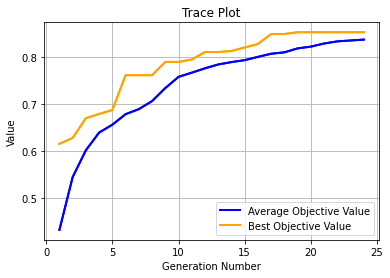

Execution time: 10022.800121068954 s
Evaluation number: 480
The best objective value is: 0.8534883720930233
The best variables are: 
0.58294677734375	0.32422637939453125	0.30072021484375	0.04949951171875	0.7431049346923828	0.2672138214111328	0.05133056640625	0.7260284423828125	-0.12939453125	-0.7308349609375	


In [12]:
# 构建问题
@ea.Problem.single
def evalVars(Vars):  # 定义目标函数（含约束）
    f = evalWinRate(Vars)  # 计算目标函数值
    CV = np.array(evalBetterThanNeighbour(Vars))
    # f = evalBetterThanNeighbour(Vars)  # 计算目标函数值
    # CV = np.array(0.5-evalWinRate(Vars))
    return f, CV
dim = 10
# varTypes = np.ones(dim) # 整数
varTypes = np.zeros(dim) # 实数
# lb = np.ones(dim)*1
# ub = np.ones(dim)*20
lb = np.ones(dim)*-1
ub = np.ones(dim)*1
problem = ea.Problem(name='演化计算求解最优评估函数',
                        M=1,  # 目标维数
                        maxormins=[-1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                        # maxormins=[1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                        Dim=dim,  # 决策变量维数
                        varTypes=varTypes,  # 决策变量的类型列表，0：实数；1：整数
                        lb=lb,  # 决策变量下界
                        ub=ub,  # 决策变量上界
                        evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                    ea.Population(Encoding='RI', NIND=20),
                                    MAXGEN=50,  # 最大进化代数。
                                    # MAXGEN=10,  # 最大进化代数。
                                    logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                    trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                    maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, seed=1, verbose=True, drawing=1, outputMsg=True, drawLog=False, saveFlag=True, dirName='result')
# 第一次实验（离散0-20，胜率为目标，打败邻居为约束）
# Execution time: 832.7836029529572 s
# Evaluation number: 220
# The best objective value is: 1.0
# The best variables are:
# 9	10	18	5	19	15	18	13	8	3
# 第二次实验：
# Execution time: 1341.5104522705078 s
# Evaluation number: 200
# The best objective value is: -0.5
# The best variables are:
# 16	14	18	18	20	20	13	12	18	15